## Topic Segmentation

### Fetching and preprocessing tweets

In [1]:
# Add project path to the PYTHONPATH

import os
import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [2]:
from nlp.dataset import Dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matheus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
filename = '../datasets/topic_segmentation/1183377763962671104-1182876466129887233_nobel.csv'
dataset = Dataset(filename, label_col='label', text_col='text')
dataset.load()
dataset.preprocess_texts(lemmatization=True, no_emoji=True)

Time to clean up: 21.42 sec


In [4]:
df = dataset.dataframe
df.cleaned.head()

0    pm abiy ahmed not exercise power control disob...
1                              care fact receive nobel
2    lithium ion battery work earns nobel prize che...
3    congratulation nobel committee give literature...
4                 wow know obama nobel peace prize win
Name: cleaned, dtype: object

In [5]:
df.head()

,id,date,user,text,cleaned
0,1183377763962671104,2019-10-13 13:43:39,Tsega36762615,@AbiyAhmedAli If PM Abiy Ahmed not exercising...,pm abiy ahmed not exercise power control disob...
1,1183377693879832576,2019-10-13 13:43:22,LisaLynn316,@gtconway3d He only cares about the fact she r...,care fact receive nobel
2,1183377645049761794,2019-10-13 13:43:11,michaelbrodsky1,Lithium-Ion Batteries Work Earns Nobel Prize i...,lithium ion battery work earns nobel prize che...
3,1183377643623866368,2019-10-13 13:43:10,yuranahua,"Congratulations, Nobel Committee, you just gav...",congratulation nobel committee give literature...
4,1183377618390962182,2019-10-13 13:43:04,RKJ65,"Wow, @realDonaldTrump. Did you know that Obama...",wow know obama nobel peace prize win


In [6]:
preprocessed_tweets = [tweet.split() for tweet in df.cleaned]
preprocessed_tweets[1:2]

[['care', 'fact', 'receive', 'nobel']]

In [7]:
import gensim

In [8]:
%%time
dictionary = gensim.corpora.Dictionary(preprocessed_tweets)
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
bow_corpus = [dictionary.doc2bow(tweets) for tweets in preprocessed_tweets]

CPU times: user 280 ms, sys: 4.14 ms, total: 284 ms
Wall time: 282 ms


In [9]:
document_num = 0
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 0 ("ahmed") appears 1 time.
Word 1 ("aung") appears 1 time.
Word 2 ("control") appears 1 time.
Word 3 ("democracy") appears 1 time.
Word 4 ("like") appears 1 time.
Word 5 ("party") appears 1 time.
Word 6 ("pm") appears 1 time.
Word 7 ("power") appears 1 time.
Word 8 ("san") appears 1 time.
Word 9 ("suu") appears 1 time.
Word 10 ("winner") appears 1 time.


## Coherence model for LSA

### Coherence model

In [10]:
from gensim.models import LsiModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

In [11]:
%%time
def get_coherence_models(start, end, method):
    num_topics_values = range(start, end + 1)
    models = []
    coherence_values = {
        'u_mass': [],
        'c_v': [],
        'c_uci': [],
        'c_npmi': []
    }

    for num_topics in num_topics_values:
        model = gensim.models.LdaMulticore(bow_corpus, 
                                           num_topics=num_topics, 
                                           id2word=dictionary,                                    
                                           passes=20,
                                           workers=5,
                                           iterations=400)
        if method == 'lsa' or method == 'lsi':
            model = LsiModel(bow_corpus, num_topics=num_topics, id2word = dictionary)

        models.append(model)

        u_mass_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='u_mass')
        coherence_values['u_mass'].append(u_mass_coherence_model.get_coherence())

        c_v_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_v')
        coherence_values['c_v'].append(c_v_coherence_model.get_coherence())

        c_uci_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_uci')
        coherence_values['c_uci'].append(c_uci_coherence_model.get_coherence())

        c_npmi_coherence_model = CoherenceModel(model=model, corpus=bow_corpus, texts=preprocessed_tweets, coherence='c_npmi')
        coherence_values['c_npmi'].append(c_npmi_coherence_model.get_coherence())
        
    return (models, coherence_values)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


### Graph plotting

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def plot_graphs(num_topics_values, start, end, coherence_values):
    plt.figure(figsize=(20,10))

    plt.subplot(2,2,1)
    plt.xticks(np.arange(start, end, 1.0))
    plt.plot(num_topics_values, coherence_values['u_mass'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
             marker='o', markerfacecolor='#4a86e8', markersize=8) 
    plt.title('Coerência x Número de tópicos (u_mass)') 
    plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
    plt.grid()
    plt.ylabel('Coerência (Placar)') 
    plt.xlabel('Número de tópicos') 

    plt.subplot(2,2,2)
    plt.xticks(np.arange(start, end, 1.0))
    plt.plot(num_topics_values, coherence_values['c_v'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
             marker='o', markerfacecolor='#4a86e8', markersize=8) 
    plt.title('Coerência x Número de tópicos (c_v)') 
    plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
    plt.grid()
    plt.ylabel('Coerência (Placar)') 
    plt.xlabel('Número de tópicos') 

    plt.subplot(2,2,3)
    plt.xticks(np.arange(start, end, 1.0))
    plt.plot(num_topics_values, coherence_values['c_uci'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
             marker='o', markerfacecolor='#4a86e8', markersize=8) 
    plt.title('Coerência x Número de tópicos (c_uci)') 
    plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
    plt.grid()
    plt.ylabel('Coerência (Placar)') 
    plt.xlabel('Número de tópicos') 

    plt.subplot(2,2,4)
    plt.xticks(np.arange(start, end, 1.0))
    plt.plot(num_topics_values, coherence_values['c_npmi'], color='#8eb3f1', linestyle='solid', linewidth = 2, 
             marker='o', markerfacecolor='#4a86e8', markersize=8) 
    plt.title('Coerência x Número de tópicos (c_npmi)') 
    plt.rc('grid', linestyle='dashed', linewidth=1, color='#b9b9b9')
    plt.grid()
    plt.ylabel('Coerência (Placar)') 
    plt.xlabel('Número de tópicos') 


    plt.show() 

#### LDA Graphs

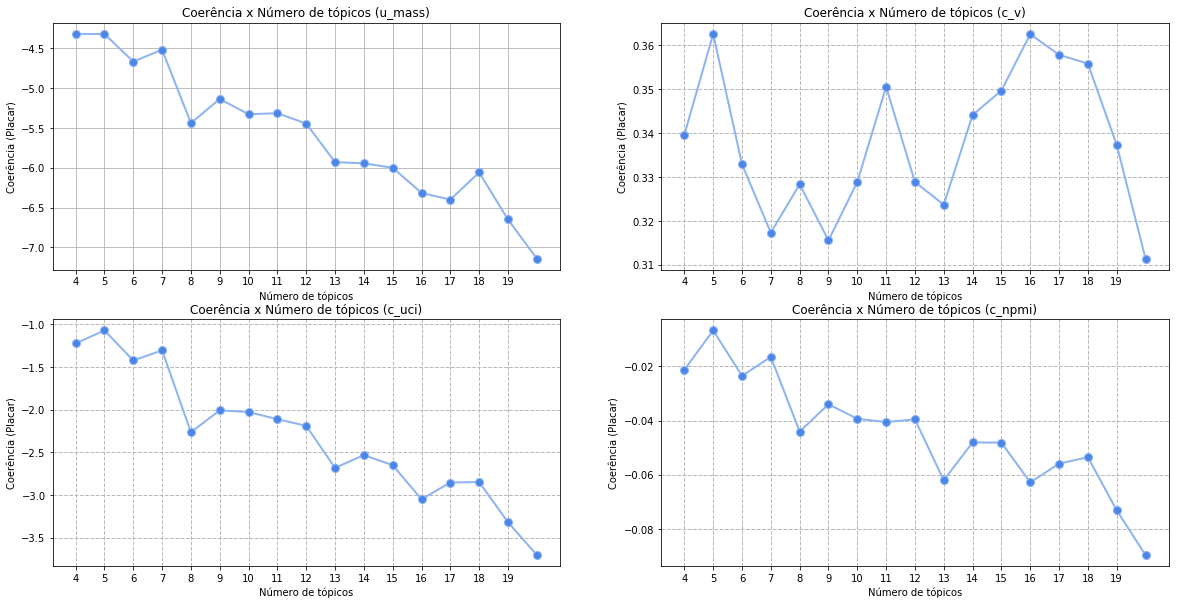

In [14]:
start = 4
end = 20
num_topics_values = range(start, end + 1)
(lda_models, coherence_values) = get_coherence_models(start, end, method='lda')

plot_graphs(num_topics_values, start, end, coherence_values)

#### LSA Graphs

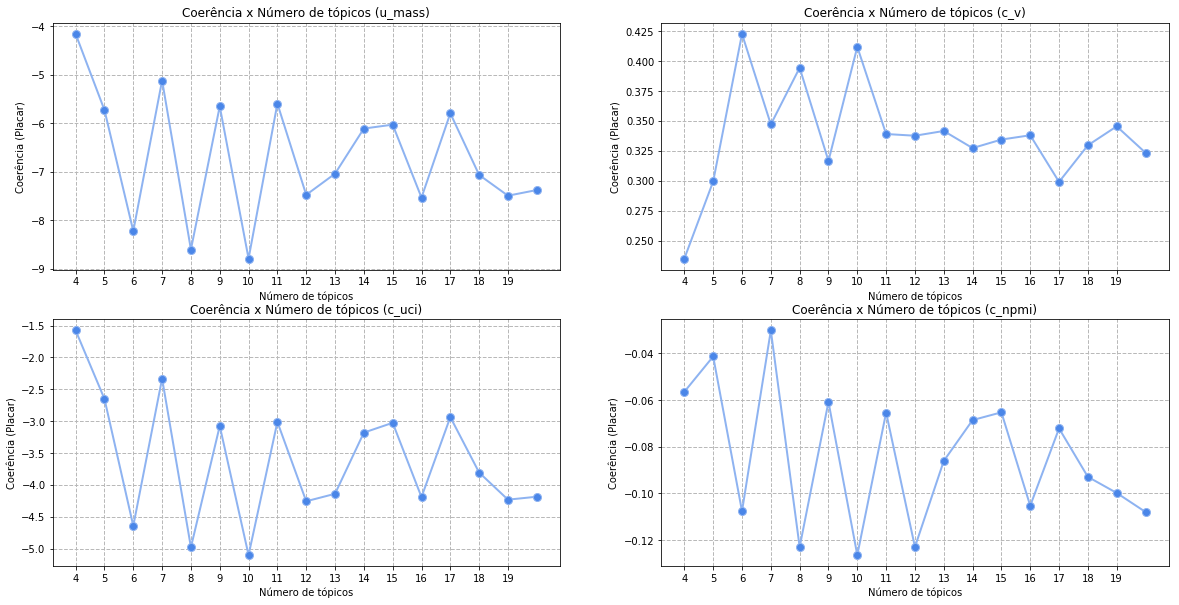

In [22]:
start = 4
end = 20
num_topics_values = range(start, end + 1)
(lsa_models, coherence_values) = get_coherence_models(start, end, method='lsa')

plot_graphs(num_topics_values, start, end, coherence_values)

In [24]:
lsa_models[2].print_topics()

[(0,
  '-0.442*"ahmed" + -0.367*"minister" + -0.366*"prime" + -0.313*"ethiopia" + -0.288*"ethiopian" + -0.171*"get" + -0.149*"year" + -0.143*"pm" + -0.120*"winner" + -0.120*"eritrea"'),
 (1,
  '-0.445*"get" + 0.258*"prime" + 0.256*"ahmed" + 0.254*"minister" + -0.192*"give" + -0.183*"one" + -0.176*"year" + 0.174*"ethiopian" + -0.158*"greta" + -0.143*"work"'),
 (2,
  '-0.686*"get" + 0.417*"winner" + 0.220*"literature" + 0.175*"handke" + 0.163*"year" + 0.154*"peter" + 0.152*"via" + 0.119*"greta" + -0.115*"prime" + -0.114*"minister"'),
 (3,
  '-0.677*"greta" + -0.446*"thunberg" + 0.310*"winner" + -0.156*"via" + -0.119*"no" + -0.118*"climate" + 0.111*"get" + -0.107*"committee" + 0.103*"work" + 0.092*"literature"'),
 (4,
  '0.500*"winner" + -0.336*"literature" + -0.331*"handke" + -0.281*"peter" + -0.211*"price" + 0.203*"ethiopia" + -0.157*"genocide" + -0.154*"minister" + -0.153*"prime" + -0.120*"work"'),
 (5,
  '0.393*"year" + -0.374*"get" + 0.359*"work" + -0.274*"winner" + -0.231*"literatur

### Model visualization

In [15]:
import pyLDAvis.gensim

In [20]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(lda_models[1], bow_corpus, dictionary, sort_topics=False)

/home/matheus/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.089500  0.101545       1        1  28.975475
1      0.077299 -0.291954       2        1  16.797853
2     -0.331973 -0.002371       3        1  15.913403
3      0.110387  0.038326       4        1  13.909332
4      0.054786  0.154454       5        1  24.403934, topic_info=    Category         Freq             Term        Total  loglift  logprob
0    Default  1302.000000            ahmed  1302.000000  30.0000  30.0000
141  Default   855.000000         minister   855.000000  29.0000  29.0000
143  Default   844.000000            prime   844.000000  28.0000  28.0000
156  Default   960.000000         ethiopia   960.000000  27.0000  27.0000
140  Default   833.000000        ethiopian   833.000000  26.0000  26.0000
54   Default   888.000000            greta   888.000000  25.0000  25.0000
25   Default   631.000000       literature   631.000000  24.0000  24.0000
56   Default   512.000000         thunberg   512.000000  23.0000  23.0000
6    Default   560.000000               pm   560.000000  22.0000  22.0000
345  Default   453.000000           handke   453.000000  21.0000  21.0000
10   Default   870.000000           winner   870.000000  20.0000  20.0000
155  Default   384.000000          eritrea   384.000000  19.0000  19.0000
22   Default   432.000000   congratulation   432.000000  18.0000  18.0000
43   Default   352.000000            peter   352.000000  17.0000  17.0000
15   Default   335.000000        chemistry   335.000000  16.0000  16.0000
27   Default   418.000000            obama   418.000000  15.0000  15.0000
66   Default  1314.000000              get  1314.000000  14.0000  14.0000
203  Default   260.000000           physic   260.000000  13.0000  13.0000
14   Default   247.000000          battery   247.000000  12.0000  12.0000
313  Default   234.000000              ali   234.000000  11.0000  11.0000
207  Default   555.000000              via   555.000000  10.0000  10.0000
830  Default   225.000000  nobelpeaceprize   225.000000   9.0000   9.0000
72   Default   387.000000            trump   387.000000   8.0000   8.0000
275  Default   330.000000             even   330.000000   7.0000   7.0000
23   Default   305.000000         genocide   305.000000   6.0000   6.0000
16   Default   184.000000              ion   184.000000   5.0000   5.0000
46   Default   256.000000        rejection   256.000000   4.0000   4.0000
124  Default   321.000000        president   321.000000   3.0000   3.0000
752  Default   220.000000           effort   220.000000   2.0000   2.0000
62   Default   178.000000         conflict   178.000000   1.0000   1.0000
..       ...          ...              ...          ...      ...      ...
461   Topic5    79.561249          instead    87.891106   1.3109  -5.6483
85    Topic5    92.602257              yet   104.189362   1.2925  -5.4966
297   Topic5    62.675560           norway    67.636284   1.3343  -5.8869
172   Topic5   213.794006             want   275.142426   1.1582  -4.6599
509   Topic5   121.070312             help   155.480713   1.1603  -5.2285
190   Topic5    66.363121              ago    74.733696   1.2916  -5.8297
437   Topic5   110.308578            child   140.614227   1.1677  -5.3216
21    Topic5   305.689606        committee   565.850464   0.7947  -4.3023
41    Topic5   263.778992             make   470.082306   0.8326  -4.4498
24    Topic5   401.636414             give   836.800354   0.6764  -4.0293
98    Topic5   306.979095           people   608.744019   0.7258  -4.2981
67    Topic5   285.483978               go   591.206177   0.6824  -4.3707
186   Topic5   168.487671           change   286.101929   0.8809  -4.8980
507   Topic5   146.504898           leader   244.724579   0.8974  -5.0378
126   Topic5   250.213852            world   558.581177   0.6073  -4.5026
66    Topic5   432.286072              get  1314.147217   0.2986  -3.9558
78    Topic5   156.450470  

## Script

In [17]:
from topic_segmentation.get_topics import get_topics

In [18]:
lda_topics = get_topics('nobel', '../datasets/topic_segmentation', method='lda', count=6)
print(lda_topics)

Time to clean up: 20.78 sec
[['ahmed', 'congratulation', 'eritrea', 'ethiopia', 'ethiopian', 'minister', 'nobelpeaceprize', 'pm', 'prime', 'winner'], ['author', 'call', 'greta', 'handke', 'literature', 'old', 'peter', 'thunberg', 'tokarczuk', 'via'], ['africa', 'give', 'laureate', 'leader', 'medicine', 'people', 'physic', 'want', 'winner', 'work'], ['battery', 'chemistry', 'ever', 'first', 'get', 'go', 'letter', 'rejection', 'work', 'year'], ['change', 'deserves', 'get', 'give', 'greta', 'make', 'man', 'price', 'world', 'year'], ['committee', 'deserve', 'get', 'give', 'greta', 'obama', 'one', 'say', 'trump', 'well']]


In [19]:
lsa_topics = get_topics('nobel', '../datasets/topic_segmentation', method='lsa', count=6)
lsa_topics

Time to clean up: 19.86 sec


[['ahmed', 'ethiopia', 'ethiopian', 'get', 'minister', 'pm', 'prime', 'year'],
 ['ahmed', 'ethiopian', 'get', 'give', 'minister', 'one', 'prime', 'year'],
 ['get', 'greta', 'handke', 'literature', 'peter', 'via', 'winner', 'year'],
 ['climate', 'committee', 'get', 'greta', 'no', 'thunberg', 'via', 'winner'],
 ['ethiopia',
  'genocide',
  'handke',
  'literature',
  'minister',
  'peter',
  'price',
  'winner'],
 ['get', 'handke', 'literature', 'rejection', 'via', 'winner', 'work', 'year']]